# Softmax Preserves Order, Is Translation Invariant But Not Invariant Under Scaling.

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Brain_Dump-red)
![Tag](https://img.shields.io/badge/Level-Beginner-green)

```{contents}
:local:
```

In [1]:
%config InlineBackend.figure_format = 'svg'

from __future__ import annotations

import torch
from torch import nn
from rich.pretty import pprint
import matplotlib.pyplot as plt

import sys
from pathlib import Path

from IPython.display import display

def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
else:
    raise ImportError("Root directory not found.")

use_svg_display()

## Problem Formulation

Consider a classification problem with a dataset $\mathcal{S}$ with $N$ samples,
defined formally below,

$$
\mathcal{S} \overset{\mathrm{iid}}{\sim} \mathcal{D} = \left \{ \left(\mathbf{x}^{(n)}, y^{(n)} \right) \right \}_{n=1}^N \in \left(\mathcal{X}, \mathcal{Y} \right)^N
$$

where

-   $\mathcal{X}$ is the input space, $\mathcal{X} \subseteq \mathbb{R}^{D}$,
-   $\mathcal{Y}$ is the output space, $\mathcal{Y} \subseteq \mathbb{Z}$,
-   $\mathbf{x}^{(n)} \in \mathcal{X}$ is the input feature vector of the $n$-th
    sample,
-   $y^{(n)} \in \mathcal{Y}$ is the output label of the $n$-th sample,
-   $\mathcal{D}$ is the underlying, true but unknown, data distribution,
-   $\mathcal{S}$ is the dataset, a finite sample drawn $\mathrm{iid}$ (the
    independent and identically distributed assumption) from $\mathcal{D}$.

Given the classification setuo, the goal is to define a functional form
$f(\cdot)$ that maps an input vector $\mathbf{x}$ to a predicted output label
$y$. This mapping is typically represented by a function
$f: \mathcal{X} \rightarrow \mathcal{Y}$, which takes an input $\mathbf{x}$ from
the input space $\mathcal{X}$ and predicts an output label $y$ from the output
space $\mathcal{Y}$. Consequently, for a classification problem with $K$
discrete classes $\mathcal{C}_{k}$, where $k=1 , \ldots, K$, the output space
$\mathcal{Y}$ corresponds to the set of these $K$ classes, often represented as
$\{1, 2, \ldots, K\}$ or $\{0, 1, \ldots, K-1\}$, depending on the indexing
convention. Therefore, $y \in \mathcal{Y}$ is the class label assigned to the
input vector $\mathbf{x}$ {cite}`bishop2007`.

### Functional Form of $f$

The function $f$ can be explicitly defined in terms of parameters that need to
be learned from the data $\mathcal{S}$. A common approach in machine learning is
to use a parameterized model $f_{\boldsymbol{\theta}}$, where
$\boldsymbol{\theta} \in \boldsymbol{\Theta}$ denotes the parameters of the
model. This model aims to approximate the true but unknown function that maps
inputs to outputs in the underlying data distribution $\mathcal{D}$.

For a given input vector $\mathbf{x}^{(n)}$, the functional form of the model
can be expressed as:

$$
y^{(n)} = f_{\boldsymbol{\theta}}\left(\mathbf{x}^{(n)}\right)
$$

and the functional form of the estimated label $\hat{y}^{(n)}$ can be expressed
as:

$$
\hat{y}^{(n)} = f_{\hat{\boldsymbol{\theta}}}\left(\mathbf{x}^{(n)}\right)
$$

For simplicity, we would consider the family of **_linear models_**, where the
functional form can be expressed as:

$$
f_{\boldsymbol{\theta}}\left(\mathbf{x}\right) = \boldsymbol{\theta}^{\top} \mathbf{x} + b
$$

where $\boldsymbol{\theta} \in \mathbb{R}^{D}$ is the weight vector,
$b \in \mathbb{R}$ is the bias term, and
$\boldsymbol{\theta} = \{\boldsymbol{\theta}, b\}$ are the parameters of the
model. We then seek $\hat{\boldsymbol{\theta}}$ that minimizes the discrepancy
between the predicted label $\hat{y}^{(n)}$ and the true label $y^{(n)}$ for all
samples in the dataset $\mathcal{S}$ via an optimization procedure (learning
algorithm) $\mathcal{A}$ over some loss function $\mathcal{L}$.

It is also worth noting the functional form is usually extended to include an
activation (inverse is the link function in statistics theory) function
$\sigma(\cdot)$, which introduces non-linearity to the model, and more
importantly, ensures the output of the model is a valid probability distribution
over the classes (note ensuring the output is a valid probability distribution
does not equate to the model being well-calibrated). In our context, we would
treat the activation function as the **_softmax function_** and is only applied
to the output layer of the model.

$$
f_{\boldsymbol{\theta}}\left(\mathbf{x}\right) = \sigma\left(\underbrace{\boldsymbol{\theta}^{\top} \mathbf{x} + b}_{\mathbf{z}}\right)
$$

In the setting of multiclass classification, it is common to represent the
predicted $\hat{y}$ as a $K$-dimensional vector, where $K$ is the number of
classes. And thus, the output of the model can be expressed as:

$$
\hat{\boldsymbol{y}} := f_{\boldsymbol{\theta}}\left(\mathbf{x}\right) = \begin{bmatrix} \hat{y}_1 & \hat{y}_2 & \cdots & \hat{y}_K \end{bmatrix}
$$

with $\hat{y}_k = p\left(y = \mathcal{C}_k \mid \mathbf{x}\right)$, the
probability of the input vector $\mathbf{x}$ belonging to class $\mathcal{C}_k$.

To this end, it would be incomplete not to mention the probabilistic
interpretation of the classification problem. We state very briefly in the next
section. For a more rigorous treatment, we refer the reader to chapter 4 of
_Pattern Recognition and Machine Learning_ by Bishop {cite}`bishop2007`.

### Probabilistic Interpretation

We can also divide the classification to either **_discriminative_** or
**_generative_** models. Discriminative models learn the decision boundary
directly from the data, while generative models learn the joint distribution of
the input and output, and then use Bayes' rule to infer the decision boundary.

For example, if we look through the multiclass problem through the lens of
generative models, our goal is basically to find
$p\left(\mathcal{C}_k \mid \mathbf{x}\right)$. One approach to determine this
conditional probability is to adopt a generative approach in which we model the
class-conditional densities given by
$p\left(\mathbf{x} \mid \mathcal{C}_k\right)$, together with the prior
probabilities $p\left(\mathcal{C}_k\right)$ for the classes, and then we compute
the required posterior probabilities using Bayes' theorem {cite}`bishop2007`,

$$
p\left(\mathcal{C}_k \mid \mathbf{x} ; \boldsymbol{\theta} \right)=\frac{p\left(\mathbf{x} \mid \mathcal{C}_k\right) p\left(\mathcal{C}_k\right)}{p(\mathbf{x})}
$$

### Unnormalized Logits

At this juncture, we would take a look at what happens before the activation
function, in our case, the softmax function is applied. The linear projection
layer, often the head/output layer, of the model
$f_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$ (pre-softmax), yields what we
often referred to as the **_logits_** or **_unnormalized scores_**. We often
denote the logits as $\mathbf{z}$, and it is a $K$-dimensional vector, where $K$
is the number of classes.

$$
\mathbf{z} \in \mathbb{R}^{K} = \boldsymbol{\theta}^{\top} \mathbf{x} + b
$$

where each element $z_k$ of the vector $\mathbf{z}$ is the unnormalized score of
the $k$-th class.

Since the logits are unnormalized and unbounded, it follows that we need to
_induce_ the model to produce a valid probability distribution over the classes.
This is where the softmax function comes into play.

```{admonition} Enough is Enough
:class: warning

I don't even know enough to continue the theoretical blabbering. I would stop
here and transit to the highlight and regurgitate the key points of the softmax
function.
```

## Softmax Function

The softmax function (a **_vector function_**) takes as input a vector
$\mathbf{z} = \begin{bmatrix} z_1 & z_2 & \cdots & z_K \end{bmatrix}^{\top} \in \mathbb{R}^{K}$
of $K$ real numbers, and normalizes it into a probability distribution
consisting of $K$ probabilities proportional to the exponentials of the input
numbers. That is, prior to applying softmax, some vector components could be
negative, or greater than one; and might not sum to 1 ; but after applying
softmax, each component will be in the interval $(0,1)$, and the components will
add up to $1$, so that they can be interpreted as probabilities. Furthermore,
the larger input components will correspond to larger probabilities.

For a vector $\mathbf{z} \in \mathbb{R}^{K}$ of $K$ real numbers, the standard
(unit) softmax function $\sigma: \mathbb{R}^K \mapsto(0,1)^K$, where $K \geq 1$,
is defined by the formula

$$
\sigma(\mathbf{z})_j=\frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} \text { for } j=1, \ldots, K
$$

More concretely, we can write explicitly the mapping as:

$$
\begin{aligned}
\sigma(\cdot): \mathbb{R}^{K} & \rightarrow(0,1)^{K} \\
\mathbf{z} & \mapsto \begin{bmatrix} \sigma(\mathbf{z})_1 & \sigma(\mathbf{z})_2 & \cdots & \sigma(\mathbf{z})_K \end{bmatrix}^{\top} \\
\begin{bmatrix} z_1 & z_2 & \cdots & z_K \end{bmatrix}^{\top} & \mapsto \begin{bmatrix} \frac{e^{z_1}}{\sum_{k=1}^K e^{z_k}} & \frac{e^{z_2}}{\sum_{k=1}^K e^{z_k}} & \cdots & \frac{e^{z_K}}{\sum_{k=1}^K e^{z_k}} \end{bmatrix}^{\top}
\end{aligned}
$$

In particular, for any element $z_j$ of the input vector $\mathbf{z}$, the
softmax function computes the exponential of the element and normalizes it by
the sum of the exponentials of all the elements in the input vector.

### Softmax Obeys The Three Axioms of Probability (Kolmogorov Axioms)

First of all, softmax induces a valid probability distribution over the classes.
Why so? We first need to understand the three axioms of probability, also known
as the Kolmogorov axioms.

Consider the probability space defined over the triplet
$\left(\Omega, \mathcal{F}, \mathbb{P}\right)$, where $\Omega$ is the sample
space, $\mathcal{F}$ is the sigma-algebra event space (collection of events),
and $\mathbb{P}$ is the probability function.

A probability function $\mathbb{P}$ defined over the probability space must
satisfy the three axioms below. Recall that the **probability function** in a
well defined **experiment** is a function $\mathbb{P}: \mathcal{F} \to [0, 1]$.
Informally, for any event $A$, $\mathbb{P}(A)$ is defined as the probability of
event $A$ happening.

This probability function/law $\mathbb{P}(A)$ must satisfy the following three
axioms:

```{prf:axiom} Non-Negativity
:label: how-does-softmax-work-non-negativity

$\mathbb{P}(A) \geq 0$ for any event $A \subseteq \S$.
```

```{prf:axiom} Normalization
:label: how-does-softmax-work-normalization

$\sum_{i=1}^{n}\mathbb{P}(A_i) = 1$
    where $A_i$ are all possible outcomes for $i = 1, 2,..., n$.
```

```{prf:axiom} Additivity
:label: how-does-softmax-work-additivity

Given a countable sequence of
    **disjoint events** $A_1, A_2, ..., A_n,... \subset \S$, we have

$$
\mathbb{P}\left(\bigsqcup_{i=1}^{\infty} A_i \right) = \sum_{i=1}^{\infty}\mathbb{P}[A_i]
$$
```

#### Non-Negativity

To satisfy the first axiom, we need to show that $\sigma(\mathbf{z})_j \geq 0$
for all $j$.

It is easy to see that the exponential function $e^{z_j}$ is always positive for
any real number $z_j$. Therefore, $e^{z_j} > 0$ for all $i$. The denominator is
a sum of positive terms, thus also positive. A positive number divided by
another positive number is positive, hence $\sigma(\mathbf{z})_j > 0$ for all
$i$. This satisfies the non-negativity axiom.

#### Normalization

To satisfy the second axiom, we need to prove that the sum of the softmax
function outputs equals 1, i.e., $\sum_{k=1}^{K} \sigma(\mathbf{z})_k = 1$.

By definition of softmax, for any element $z_j$ of the input vector
$\mathbf{z}$, we have
$\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$, and summing
over all $K$ classes, we have

$$
\begin{aligned}
\sum_{j=1}^{K} \sigma(\mathbf{z})_j & = \sum_{j=1}^{K} \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} \\
& = \frac{\sum_{j=1}^{K} e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} \\
& = 1
\end{aligned}
$$

This shows that the sum of the outputs of the softmax function equals 1,
satisfying the normalization axiom.

#### Additivity

This is evident because if we treat each instance $z_j$ as a disjoint event
since each $z_j$ can only belong to one class, then the events (or classes) form
a countable sequence of disjoint events.

#### Calibration

While softmax ensures that the output of the model is a valid probability
distribution over the classes, it does not guarantee that the model is
well-calibrated. A well-calibrated model is one that produces predicted
probabilities that are close to the true probabilities.

### Implementation

Here we show a simple implementation of the softmax function in PyTorch.

In [2]:
class Softmax:
    def __init__(self, dim: int | None = None) -> None:
        """
        Initialize the softmax function.
        """
        self.dim = dim

    def __call__(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the softmax function for a given input.
        """
        numerator = torch.exp(z)
        denominator = torch.sum(numerator, dim=self.dim, keepdim=True)
        g = numerator / denominator
        return g

We do a rough comparison of the softmax function implemented in PyTorch with the
readily available implementation in PyTorch.

In [3]:
z = torch.randn((2, 5), requires_grad=True, dtype=torch.float32)
pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_probs = pytorch_softmax(z)
pprint(pytorch_softmax_probs)

my_softmax = Softmax(dim=1)
my_softmax_probs = my_softmax(z)
pprint(my_softmax_probs)

torch.testing.assert_close(
    pytorch_softmax_probs, my_softmax_probs, rtol=1.3e-6, atol=1e-5, msg="Softmax function outputs do not match."
)

tensor([[0.1446, 0.0695, 0.2901, 0.3618, 0.1339],
│   │   [0.1064, 0.3404, 0.2165, 0.2250, 0.1117]], grad_fn=<SoftmaxBackward0>)

tensor([[0.1446, 0.0695, 0.2901, 0.3618, 0.1339],
│   │   [0.1064, 0.3404, 0.2165, 0.2250, 0.1117]], grad_fn=<DivBackward0>)

## Softmax Preserves Order (Monotonicity)

Order preservation, in the context of mathematical functions, refers to a
property where the function maintains the relative ordering of its input
elements in the output. Specifically, for a function $f$ to be considered
order-preserving, the following condition must hold:

Given any two elements $a$ and $b$ in the domain of $f$, if $a > b$, then
$f(a) > f(b)$.

For the softmax function, which is defined for a vector
$\mathbf{z} = \begin{bmatrix} z_1 & z_2 & \cdots & z_K \end{bmatrix}^{\top}$ of
$K$ real numbers as:

$$
\sigma(\mathbf{z})_j=\frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} \text { for } j=1, \ldots, K
$$

and for it to be order-preserving, it must satisfy the condition that for any
two elements $z_i$ and $z_j$ in the input vector $\mathbf{z}$, if $z_i > z_j$,
then $\sigma(\mathbf{z})_i > \sigma(\mathbf{z})_j$. The proof is relatively
simple, since the exponential function is monotonically increasing.

We can show one example in code:

In [4]:
logits = torch.tensor([[2.0, 1.0, 3.0, 5.0, 4.0]], dtype=torch.float32)
my_softmax = Softmax(dim=1)
my_softmax_probs = my_softmax(logits)

_, indices_logits = torch.sort(logits, descending=False)
_, indices_probs = torch.sort(my_softmax_probs, descending=False)

pprint(indices_logits)
pprint(indices_probs)

torch.testing.assert_close(
    indices_logits, indices_probs, rtol=1.3e-6, atol=1e-5, msg="Softmax Ordering is not preserved?!"
)

tensor([[1, 0, 2, 4, 3]])

tensor([[1, 0, 2, 4, 3]])

Indeed, if the logits is
$\mathbf{z} = \begin{bmatrix} 2.0 & 1.0 & 3.0 & 5.0 & 4.0 \end{bmatrix}$, with
ordering of the elements $z_2 < z_1 < z_3 < z_5 < z_4$ (indices 1, 0, 2, 4, 3),
we show that the softmax function preserves the ordering of the elements in the
output probability distribution.

## Softmax Is Translation Invariance

The softmax function showcases an important characteristic known as translation
invariance. This means that if we translate each coordinate of the input vector
$\mathbf{z}$ by the same scalar value $c$, the output of the softmax function
remains unchanged. Mathematically, adding a constant vector
$\mathbf{c} = (c, \ldots, c)$ to the inputs $\mathbf{z}$ results in
$\sigma(\mathbf{z} + \mathbf{c}) = \sigma(\mathbf{z})$, because this operation
multiplies each exponent in the softmax function by the same factor $e^c$, due
to the property $e^{z_i + c} = e^{z_i} \cdot e^c$. Consequently, the ratios of
the exponents do not alter.

Given the input vector
$\mathbf{z} = \begin{bmatrix} z_1 & z_2 & \ldots & z_K \end{bmatrix}$ and a
constant scalar $c$, the translation invariance of the softmax function can be
expressed as:

$$
\sigma(\mathbf{z} + \mathbf{c})_j = \frac{e^{z_j + c}}{\sum_{k=1}^{K}
e^{z_k + c}} = \frac{e^{z_j} \cdot e^c}{\sum_{k=1}^{K} e^{z_k} \cdot e^c} =
\sigma(\mathbf{z})_j
$$

for $j = 1, \ldots, K$, where $K$ is the number of elements in vector
$\mathbf{z}$.

In code, we can demonstrate this property as follows:

In [5]:
constant = 10
translated_logits = logits + constant
translated_probs = my_softmax(translated_logits)

print("Original softmax  :", my_softmax_probs)
print("Translated softmax:", translated_probs)

torch.testing.assert_close(my_softmax_probs, translated_probs, rtol=1.3e-6, atol=1e-5, msg="Translation Invariance Violated!")

Original softmax  : tensor([[0.0317, 0.0117, 0.0861, 0.6364, 0.2341]])
Translated softmax: tensor([[0.0317, 0.0117, 0.0861, 0.6364, 0.2341]])


### Numerical Instability of the Softmax Function

Recall the softmax function as follows:

$$
\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} \quad \text{for }
j = 1, \ldots, K
$$

When elements of $\mathbf{z}$ are very large (positive or negative), computing
$e^{z_j}$ can lead to numerical instability:

-   **Overflow**: If $z_j$ is very large, $e^{z_j}$ can exceed the range of
    floating-point numbers, leading to infinity ($\infty$).
-   **Underflow**: If $z_j$ is very negative, $e^{z_j}$ can become so small that
    it's considered as zero in floating-point arithmetic.

Both situations can cause issues when computing the softmax, leading to
inaccurate results or failures in computation due to divisions by infinity or
zero.

To mitigate these issues, we leverage the invariance property of softmax to
shifts in the input vector {cite}`Goodfellow-et-al-2016`. Specifically, adding
or subtracting the same scalar from every element of $\mathbf{z}$ doesn't change
the output of the softmax function:

$$\sigma(\mathbf{z}) = \sigma(\mathbf{z} + c)$$

By choosing $c = -\max_i z_i$, we subtract the maximum element of $\mathbf{z}$
from every element. This operation ensures that the maximum value in the shifted
vector is $0$, which helps in avoiding overflow (since $e^0 = 1$ is within
range) and reduces the risk of underflow for other elements.

The numerically stable softmax function can thus be reformulated as:

$$
\sigma(\mathbf{z})_j = \frac{e^{z_j - \max_i z_i}}{\sum_{k=1}^K e^{z_k -
\max_i z_i}} \quad \text{for } j = 1, \ldots, K
$$

This reformulation achieves the following:

-   **Maximal Value Normalization**: By ensuring that the maximum exponentiated
    value is $e^0 = 1$, we prevent overflow.
-   **Relative Differences Preserved**: The operation preserves the relative
    differences between the elements of $\mathbf{z}$, ensuring the softmax
    output remains unchanged in terms of its distribution properties.
-   **Improved Numerical Stability**: The risk of underflow is also mitigated
    since subtracting a large value ($\max_i z_i$) from each $z_j$ makes the
    values more manageable for computation without affecting the ratios that
    softmax aims to model.

To this end, a rough implementation of the numerically stable softmax function
is shown below:

In [6]:
super_large_logits = torch.tensor([[1000.0, 2000.0, 3000.0, 4000.0, 5000.0]], dtype=torch.float32)
unstable_softmax = my_softmax(super_large_logits)
pprint(unstable_softmax)

def stable_softmax(z: torch.Tensor) -> torch.Tensor:
    """
    Compute the numerically stable softmax function for a given input.
    """
    max_z = torch.max(z, dim=1, keepdim=True).values
    numerator = torch.exp(z - max_z)
    denominator = torch.sum(numerator, dim=1, keepdim=True)
    g = numerator / denominator
    return g

stable_softmax_probs = stable_softmax(super_large_logits)
pprint(stable_softmax_probs)

tensor([[nan, nan, nan, nan, nan]])

tensor([[0., 0., 0., 0., 1.]])

## Softmax Is Not Invariant Under Scaling

A function $f: \mathbb{R}^D \rightarrow \mathbb{R}^D$ is said to be scale
invariant if for any positive scalar $c > 0$ and any vector
$\mathbf{x} \in \mathbb{R}^D$, the following condition holds:

$$
f(c\mathbf{x}) = f(\mathbf{x})
$$

This means that scaling the input vector $\mathbf{x}$ by any positive factor $c$
does not change the output of the function $f$. Scale invariance implies that
the function's output depends only on the direction of the vector $\mathbf{x}$
and not its magnitude.

In contrast, a function is not invariant under scaling if there exists at least
one vector $\mathbf{x} \in \mathbb{R}^D$ and one scalar $c > 0$ such that
$f(c\mathbf{x}) \neq f(\mathbf{x})$.

The softmax function is **_not_** invariant under scaling. This is because the
softmax output changes when the input vector $\mathbf{z}$ is scaled by a
positive scalar $c$, as the exponential function magnifies differences in the
scaled inputs.

The difference in softmax's response to scaling can be attributed to the
exponential operation applied to each element of the input vector before
normalization. Since the exponential function is not linear, scaling the input
vector $\mathbf{z}$ by a scalar $c$ does not merely scale the output by the same
factor, but rather changes the relative weights of the output probabilities.

Consider the input vector
$\mathbf{z} = \begin{bmatrix} 10.0 & 20.0 & 30.0 \end{bmatrix}$, and its scaled
version
$\tilde{\mathbf{z}} = c \cdot \mathbf{z} = \begin{bmatrix} 0.1 & 0.2 & 0.3 \end{bmatrix}$
where $c = 0.01$. The softmax output for the larger input vector $\mathbf{z}$ is
approximately
$\begin{bmatrix} 2.0611e-09 & 4.5398e-05 & 9.9995e-01 \end{bmatrix}$, while the
softmax output for the scaled input vector $\tilde{\mathbf{z}}$ is approximately
$\begin{bmatrix} 0.3006 & 0.3322 & 0.3672 \end{bmatrix}$ which show that the
softmax function is not invariant under scaling by comparing the softmax outputs
for the original and scaled input vectors.

Softmax of the larger input : tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])
Softmax of the smaller input: tensor([0.3006, 0.3322, 0.3672])


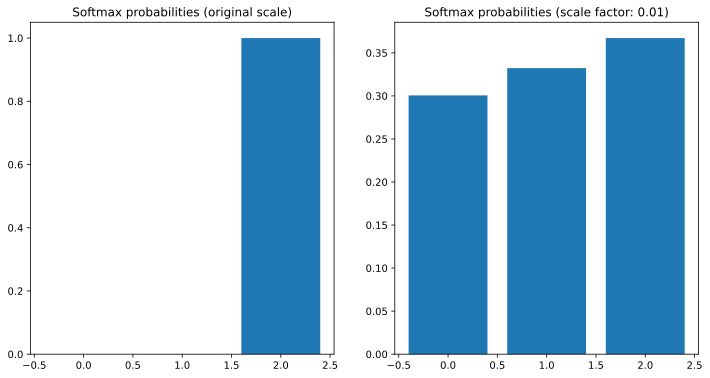

In [7]:
c = 0.01
input_large = torch.tensor([10, 20, 30], dtype=torch.float32)
input_small = c * input_large # torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)

softmax_large = Softmax(dim=0)(input_large)
softmax_small = Softmax(dim=0)(input_small)

print("Softmax of the larger input :", softmax_large)
print("Softmax of the smaller input:", softmax_small)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(softmax_large)), softmax_large)
plt.title('Softmax probabilities (original scale)')

plt.subplot(1, 2, 2)
plt.bar(range(len(softmax_small)), softmax_small)
plt.title(f'Softmax probabilities (scale factor: {c})')

plt.show()

Another example:

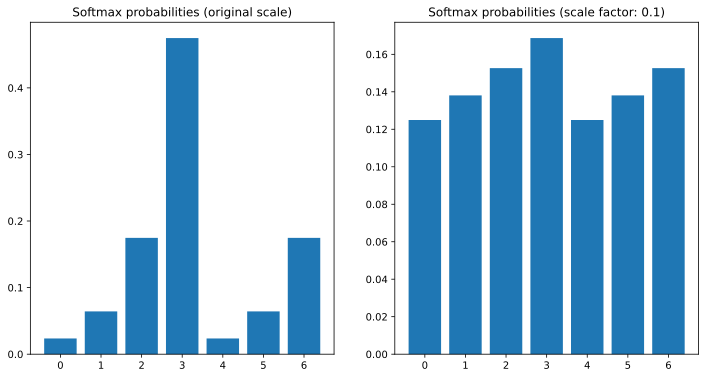

In [8]:
c = 0.1
input_large = torch.tensor([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0], dtype=torch.float32)
input_small = c * input_large

softmax_large = Softmax(dim=0)(input_large)
softmax_small = Softmax(dim=0)(input_small)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(softmax_large)), softmax_large)
plt.title('Softmax probabilities (original scale)')

plt.subplot(1, 2, 2)
plt.bar(range(len(softmax_small)), softmax_small)
plt.title(f'Softmax probabilities (scale factor: {c})')

plt.show()

## Sharpening and Dampening the Softmax Distribution

Continuing from our first example, the 3rd element of the softmax output has the
largest weight (`9.9995e-01`), thereby suppressing the other elements. The sharp
readers would have noticed that even though the 3rd element has the largest
weight, it was at a whooping $0.99995$, which is almost $1$ - which means the
rest of the elements are almost zero. As we shall briefly touch upon later,
sampling from a
[multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution)
(number of trials is 1 because we are sampling one token at each time step) with
the parameter $\boldsymbol{\pi}$, where $\boldsymbol{\pi}$ is the softmax
output, almost surely will select the 3rd element because of the high
probability. This is what we call a **_sharp_** softmax distribution.

On the other hand, if we scale the input vector by a factor $c=0.01$, even
though the ranking (order) is preserved, the softmax output is more uniformly
distributed, with the weights of the elements more evenly spread out. We can see
the 3rd element has a weight of $0.3672$, which is still the maximum in the
array, but the relative weights of the other elements are higher compared to the
original softmax output. Similarly, sampling from a multinomial distribution
with the parameter $\boldsymbol{\pi}$ this time will be more diverse, because
our $\boldsymbol{\pi}$ is more uniform (at
$\begin{bmatrix} 0.3006 & 0.3322 & 0.3672 \end{bmatrix}$ and therefore the other
two elements are likely to get selected as they are quite close to the max
weight). This is what we call a **_dampened_** softmax distribution.

For people who has toyed around with the temperature parameter in the language
model, we were told that when the temperature is high, the model is more random,
and when the temperature is low, the model is more deterministic. This is
because the temperature parameter effectively scales the logits by $T$ (the
temperature), where we can think of it as `logits = logits / (T + epsilon)`.
This is the same as scaling the logits by a factor $c = 1/T$. When $T$ is high,
the softmax distribution is more uniform, and when $T$ is low, the softmax
distribution is more sharp and the highest weight displays an one-hot manner,
where the rest of the weights are almost zero.

## Temperature

We start off this section with an extracted portion from the Wikipedia page that
is relevant to our discussion on the temperature parameter in the softmax
function.

```{epigraph}
The term "softmax" derives from the amplifying effects of the exponential on any
maxima in the input vector. For example, the standard softmax of $(1,2,8)$ is
approximately $(0.001,0.002,0.997)$, which amounts to assigning almost all of
the total unit weight in the result to the position of the vector's maximal
element (of 8).

In general, instead of $e$ a different base $b>0$ can be used. If $0<b<1$,
smaller input components will result in larger output probabilities, and
decreasing the value of $b$ will create probability distributions that are more
concentrated around the positions of the smallest input values. Conversely, as
above, if $b>1$ larger input components will result in larger output
probabilities, and increasing the value of $b$ will create probability
distributions that are more concentrated around the positions of the largest
input values.

Writing $b=e^\beta$ or $b=e^{-\beta[\mathbf{a}]}$ (for real $\beta$) yields the
expressions:

$$
\sigma(\mathbf{z})_i=\frac{e^{\beta z_i}}{\sum_{j=1}^K e^{\beta z_j}} \text { or } \sigma(\mathbf{z})_i=\frac{e^{-\beta z_i}}{\sum_{j=1}^K e^{-\beta z_j}} \text { for } i=1, \ldots, K
$$

The reciprocal of $\beta$ is sometimes referred to as the temperature,
$T=1 / \beta$, with $b=e^{1 / T}$. A higher temperature results in a more
uniform output distribution (i.e. with higher entropy, and "more random"), while
a lower temperature results in a sharper output distribution, with one value
dominating.

-- [Softmax - Wikipedia](https://en.wikipedia.org/wiki/Softmax_function)
```

More concretely, how temperature is implemented in large language models like
GPT is by scaling the logits by the temperature parameter $T$ before applying
the softmax function.

```python
logits = torch.randn((1, 3), dtype=torch.float32)
temperature = [0, 0.1, 0.5, 1, 2, 5, 10]

for t in temperature:
    scaled_logits = logits / t
    scaled_probs = my_softmax(scaled_logits)
    print(f"Temperature: {t}, Scaled Probs: {scaled_probs}")
```

So now we can define the input of the softmax function as $\frac{z}{T}$ where
$T$ is the temperature parameter. Now our softmax would be like the below:

$$
\sigma\left(\frac{\mathbf{z}}{T}\right)_j = \frac{e^{z_j / T}}{\sum_{k=1}^K e^{z_k / T}}
$$

which coincides with the definition from the Wikipedia page.

To conclude, the temperature modifies the "sharpness" of the probability
distribution without altering the order of the probabilities, a desirable
property:

-   At high temperatures ($T > 1$), the distribution becomes more uniform, but
    if $z_a > z_b$, then $\text{softmax}_T(z_a) > \text{softmax}_T(z_b)$ still
    holds. The probabilities become closer to each other, making the choice more
    "random" or "equally likely" among options, but the ranking remains the
    same.

-   At low temperatures ($T < 1$), the distribution becomes sharper, with a more
    pronounced difference between the higher and lower probabilities, amplifying
    the differences in likelihood as determined by the logits. The probability
    of the largest logit increases towards 1, while others decrease towards 0.
    Yet, the order of logits is preserved—higher logits translate to higher
    probabilities.

-   At $T = 1$, the softmax function is the standard softmax function.

### Sampling from the Softmax Distribution

Below we show the effect of temperature on multinomial sampling from the softmax
distribution. The experiements are repeated 1000 times for each temperature, and
the distribution of sampled outcomes is visualized for each temperature.

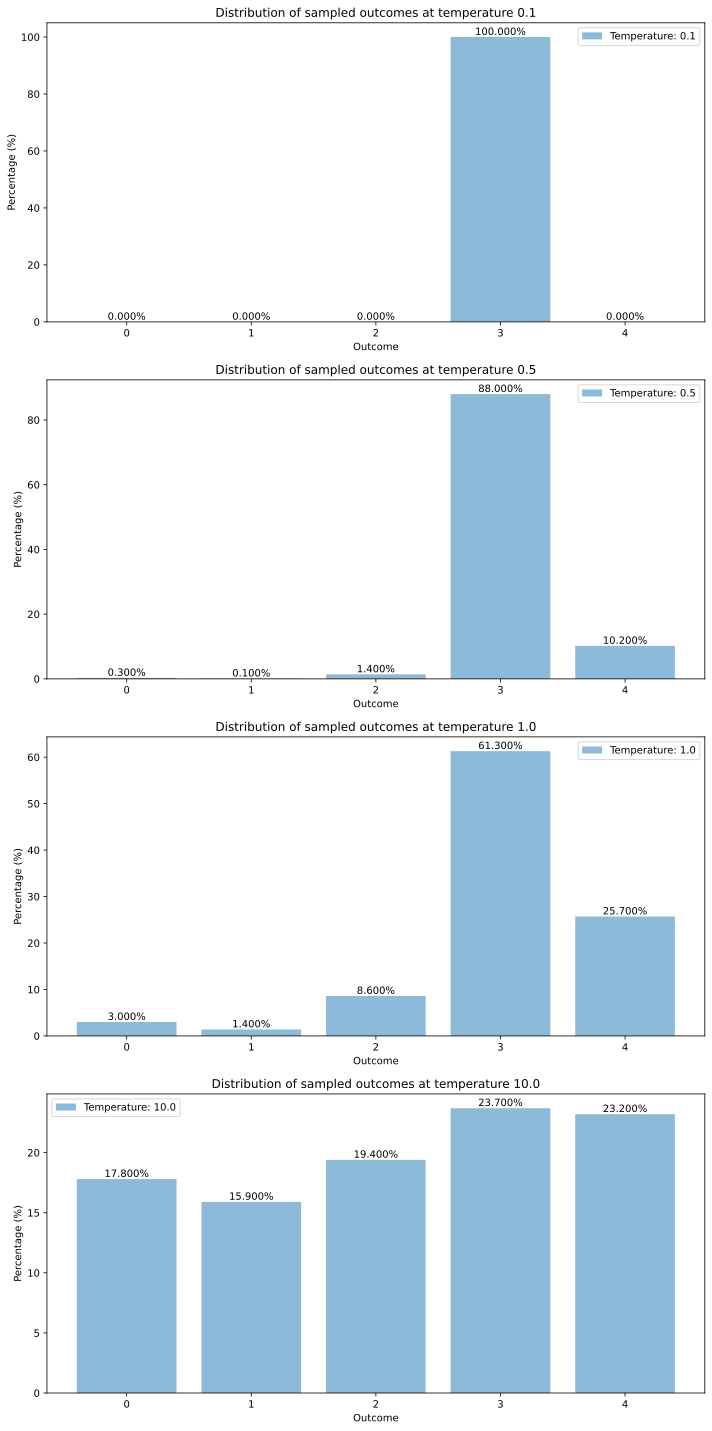

In [9]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple
import numpy as np


def demonstrate_multinomial_sampling_effect(
    logits: torch.Tensor, temperatures: List[float], num_experiments: int, epsilon: float = 1e-8
) -> Tuple[Dict[float, np.ndarray], Dict[float, List[int]]]:
    """
    Demonstrates the effect of temperature on multinomial sampling from the softmax distribution.

    Parameters
    ----------
    logits : torch.Tensor
        The input logits vector.
    temperatures : List[float]
        A list of temperatures to apply to the softmax function.
    num_experiments : int
        The number of sampling experiments to run for each temperature.
    epsilon : float, optional
        A small value added to the temperature to prevent division by zero, by default 1e-8.

    Returns
    -------
    Tuple[Dict[float, np.ndarray], Dict[float, List[int]]]
        A tuple containing two dictionaries:
        - The first maps each temperature to its corresponding softmax probabilities as a numpy array.
        - The second maps each temperature to a list of sampled outcomes (indices of logits).

    Examples
    --------
    >>> logits = torch.tensor([2.0, 1.0, 3.0, 5.0, 4.0], dtype=torch.float32)
    >>> temperatures = [0.1, 1.0, 10.0]
    >>> softmax_results, sampling_results = demonstrate_multinomial_sampling_effect(
    ...     logits, temperatures, num_experiments=1000
    ... )
    """
    softmax_results: Dict[float, np.ndarray] = {}
    sampling_results: Dict[float, List[int]] = defaultdict(list)

    for temperature in temperatures:
        # Scale logits by temperature
        scaled_logits = logits / (temperature + epsilon)
        # Apply softmax to scaled logits
        probs = torch.softmax(scaled_logits, dim=-1)
        softmax_results[temperature] = probs.numpy()

        for _ in range(num_experiments):
            sample = torch.multinomial(probs, num_samples=1, replacement=True)
            sampling_results[temperature].append(sample.item())

    return softmax_results, dict(sampling_results)


logits = torch.tensor([2.0, 1.0, 3.0, 5.0, 4.0], dtype=torch.float32)
temperatures = [0.1, 0.5, 1.0, 10.0]

num_experiments = 1000
softmax_results, sampling_results = demonstrate_multinomial_sampling_effect(
    logits, temperatures, num_experiments=num_experiments
)

outcome_counts = {
    temp: np.bincount(outcomes, minlength=len(logits)) / num_experiments * 100
    for temp, outcomes in sampling_results.items()
}

fig, axs = plt.subplots(len(temperatures), 1, figsize=(10, 5 * len(temperatures)))
for ax, temperature in zip(axs, temperatures):
    bars = ax.bar(range(len(logits)), outcome_counts[temperature], alpha=0.5, label=f"Temperature: {temperature}")
    ax.legend()
    ax.set_title(f"Distribution of sampled outcomes at temperature {temperature}")
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Percentage (%)")

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.3f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

## Softmax Is Smooth, Continuous and Differentiable

The term "softmax" is a misnomer, as one would have thought it is a
[smooth max](https://en.wikipedia.org/wiki/Smooth_maximum) - a
[smooth approximation](https://en.wikipedia.org/wiki/Smoothness) of the
[maximum function](https://en.wikipedia.org/wiki/Maximum_function). However, the
softmax function is not a smooth approximation of the maximum function, but
rather a smooth approximation of the
[argmax](https://en.wikipedia.org/wiki/Arg_max) function[^softmax-wikipedia],
where argmax is the function that outputs the **index** of the maximum element
in a vector.

The argmax function is _not_ continuous or differentiable, because it is a
discrete function that jumps from one index to another as the input vector
changes (i.e. not smooth). The softmax function, on the other hand, is a smooth
approximation of the argmax function, as it outputs a probability distribution
over the elements of the input vector, with the highest probability assigned to
the maximum element - essentially a continuous and differentiable version of the
argmax function (we call it a "softened" version of the argmax function)
{cite}`Goodfellow-et-al-2016`. Consequently, it is more appropriate to name the
function "softargmax" instead of "softmax".

To this end, it is worth mentioning that softmax gains its popularity in the
deep learning space because it is smooth and normalizer over the input vector.

The smoothness assumption is a common one in the context of deep learning,
because for when we say that the estimator function
$f_{\hat{\boldsymbol{\Theta}}}(\cdot)$ is _smooth_ with respect to the parameter
space $\hat{\boldsymbol{\Theta}}$, it means that the estimator function
$f_{\hat{\boldsymbol{\Theta}}}(\cdot)$ is _smooth_ with respect to the parameter
space $\hat{\boldsymbol{\Theta}}$ if the function is continuous and
differentiable with respect to the parameter space $\hat{\boldsymbol{\Theta}}$
up to a certain order (usually the first for SGD variants and second order for
Newton).

What this implies is that the derivative of the function with respect to the
parameter space $\hat{\boldsymbol{\Theta}}$, denoted as
$\nabla_{\hat{\boldsymbol{\Theta}}} f_{\hat{\boldsymbol{\Theta}}}(\cdot)$ is
continuous. Loosely, you can think of that a small perturbation in the parameter
space $\hat{\boldsymbol{\Theta}}$ will result in a small change in the output of
the function $f_{\hat{\boldsymbol{\Theta}}}(\cdot)$ - enabling gradient-based
optimization algorithms to work effectively as if not, then taking a step in the
direction of the gradient would not guarantee a decrease in the loss function,
slowing down convergence.

## Softmax Function via Exponential Family

For a rigorous derivation of the softmax function - which will give rise to
intuition on how sigmoid and softmax is derived from the exponential family of
distributions - we refer the reader to chapter 2.4. The Exponential Family of
Christopher Bishop's _Pattern Recognition and Machine Learning_
{cite}`bishop2007` with reference
[here](https://math.stackexchange.com/questions/328115/derivation-of-softmax-function).

## Gradient, Jacobian, and Hessian of Softmax

### Softmax as a Vector Function

The softmax function $\sigma$ represents a mapping from $\mathbb{R}^K$ to
$(0,1)^K$, where each output component $\sigma(\mathbf{z})_j$ is a function of
all input components $z_1, z_2, \ldots, z_K$. Given its vector-to-vector nature,
it does not make sense to talk about the derivative of softmax as a
scalar-valued function. Instead, the analysis of its derivatives involves the
following:

1. Which component of the output vector we are interested in, and
2. Which and how the input components affect that output component.

### Derivatives of the Softmax Function

As a result, the above considerations lands ourselves naturally into the realm
of multivariable calculus, where we consider the partial derivatives of the
softmax function - which measure the change in a specific output component in
response to a small change in a specific input component. For the $i$-th output
of softmax with respect to the $j$-th input, we denote the partial derivative
as:

$$\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}$$

This notation precisely indicates the partial derivative of the $i$-th output
with respect to the $j$-th input.

To this end, given the softmax function $\sigma$ defined on a vector
$\mathbf{z} \in \mathbb{R}^K$, the goal is to compute the partial derivative of
the $i$-th output of the softmax function with respect to the $j$ th component
of the input vector $\mathbf{z}$.

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=\frac{\partial \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}}{\partial z_j}
$$

### The Jacobian Matrix of Softmax

The formal representation of the derivatives for a vector function like softmax
is the Jacobian matrix, $\mathbf{J}_{\sigma}$, which contains all the
first-order partial derivatives. For the softmax function, the Jacobian matrix
is defined as:

$$
\mathbf{J}_{\sigma}(\mathbf{z}) = \begin{bmatrix} \frac{\partial
\sigma(\mathbf{z})_1}{\partial z_1} & \cdots & \frac{\partial
\sigma(\mathbf{z})_1}{\partial z_K} \\ \vdots & \ddots & \vdots \\
\frac{\partial \sigma(\mathbf{z})_K}{\partial z_1} & \cdots & \frac{\partial
\sigma(\mathbf{z})_K}{\partial z_K} \end{bmatrix}
$$

This matrix provides a full description of how the softmax function responds to
changes in its inputs, indicating the sensitivity of each output component to
each input component.

While "gradient" is a term often used in machine learning to describe the
derivative of a function, it strictly applies to scalar-valued functions. For
vector-valued functions like softmax, describing the comprehensive derivative
structure requires the Jacobian matrix, $\mathbf{J}_{\sigma}$, not a gradient.
Therefore, in discussions involving softmax and its impact on learning in neural
networks, it is more accurate to refer to the Jacobian matrix when considering
its derivatives.

### Derivative of the Softmax Function

To compute the partial derivative of the $i$-th component of the softmax output
with respect to the $j$-th component of the input vector $\mathbf{z}$, we
express this as:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j} = \frac{\partial
\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}}{\partial z_j}
$$

Since there is division involved, we'll apply the quotient rule of derivatives,
which for a function $f(x) = \frac{g(x)}{h(x)}$ is given by:

$$f'(x) = \frac{g'(x)h(x) - h'(x)g(x)}{[h(x)]^2}$$

For our specific case, the functions $g$ and $h$ with respect to the $i$-th
component are defined as:

$$
\begin{aligned} g_i &= e^{z_i} \\ h &= \sum_{k=1}^K e^{z_k} \end{aligned}
$$

```{admonition} Some Derivatives Tips So Far...
:class: note

Firstly, the derivative of $h$ with respect to any $z_j$ is always $e^{z_j}$.
Why? The function $h$ represents the sum of the exponentials of all components
of the input vector $\mathbf{z}$. Mathematically, $h$ is independent of the
index $i$ and is a function of all $z_k$ in the vector $\mathbf{z}$. When we
differentiate $h$ with respect to $z_j$, we treat $z_j$ as the variable and
all other $z_k$ ($k \neq j$)$ as constants.

The derivative of $e^{z_k}$ with respect to $z_j$ is $e^{z_j}$ when $k=j$
because of the basic derivative rule $d\left(e^x\right) / d x=e^x$, and it's 0
for all $k \neq j$ because the derivative of a constant is 0 . Therefore, when
you sum up all these derivatives $\left(e^{z_j}\right.$ for the term where $k=j$
and 0 for all others), the derivative of the sum $h_k$ with respect to $z_j$ is
simply $e^{z_j}$.

$$
\frac{\partial h}{\partial z_j}=\frac{\partial}{\partial z_j}\left(\sum_{k=1}^K e^{z_k}\right)=e^{z_j}
$$

Secondly, the derivative of $g_i$ with respect to $z_j$ is $e^{z_j}$ if $i=j$,
and 0 otherwise. Why? The function $g_i$ is defined as $e^{z_i}$, which only
involves a single component $z_i$ of the input vector $\mathbf{z}$. The
derivative of $g_i$ with respect to $z_j$ depends on whether $i$ equals $j$

-   If $i=j$, then $g_i=e^{z_j}$, and the derivative of $e^{z_j}$ with respect
    to $z_j$ is $e^{z_j}$ itself, following the basic exponential derivative
    rule.
-   If $i \neq j, z_i$ and $z_j$ are considered independent variables. Since
    $g_i$ does not involve $z_j$ in this case, the derivative is 0, reflecting
    the principle that the derivative of a constant (or a term that does not
    involve the variable of differentiation) is 0.

$$
\frac{\partial g_i}{\partial z_j}=\frac{\partial e^{z_i}}{\partial z_j}= \begin{cases}e^{z_j} & \text { if } i=j \\ 0 & \text { if } i \neq j\end{cases}
$$
```

#### Case 1: $i = j$

We seek to find the derivative of $\sigma(\mathbf{z})_i$ with respect to $z_j$
and since $i=j$, we seek to find the derivative of $\sigma(\mathbf{z})_i$ with
respect to $z_i$. Note it doesn't matter if we use $i$ or $j$ as the index
because it applies to _any_ index.

Given the softmax function's $i$-th component:

$$
\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$$

To find the derivative of $\sigma(\mathbf{z})_i$ with respect to $z_i$, we apply
the quotient rule:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_i}=\frac{\left(e^{z_i} \cdot \sum_{k=1}^K e^{z_k}\right)-\left(e^{z_i} \cdot e^{z_i}\right)}{\left(\sum_{k=1}^K e^{z_k}\right)^2}
$$

Simplifying this expression, where the denominator is the square of the sum of
all exponentiated components of $\mathbf{z}$, and recognizing that the numerator
simplifies to the difference between the product of $e^{z_i}$ and the sum of all
exponentiated components minus the square of $e^{z_i}$ :

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_i}=\frac{e^{z_i} \cdot \sum_{k=1}^K e^{z_k}-e^{2 z_i}}{\left(\sum_{k=1}^K e^{z_k}\right)^2}
$$

Upon substituting the definition of $\sigma(\mathbf{z})_i$ into this equation,
we observe:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_i}=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}-\left(\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}\right)^2
$$

Given that $\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$, it
follows that the derivative simplifies to:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_i}=\sigma(\mathbf{z})_i-\sigma(\mathbf{z})_i^2
$$

Thus, expressing it in a more compact form:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_i} = \sigma(\mathbf{z})_i (1 - \sigma(\mathbf{z})_i)
$$

#### Case 2: $i \neq j$

We then consider the scenario where we aim to compute the derivative of the
$i$-th component of the softmax output with respect to a different component
$z_j$, where $i \neq j$. This examines how changes in one input logit affect the
probability associated with a different class.

Given the $i$-th component of the softmax function:

$$
\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$$

To compute $\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}$ for $i \neq j$,
we again apply the quotient rule, but with an understanding that the derivative
of the numerator $e^{z_i}$ with respect to $z_j$ is 0 , since $z_i$ does not
change when $z_j$ changes:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=\frac{0-e^{z_i} \cdot e^{z_j}}{\left(\sum_{k=1}^K e^{z_k}\right)^2}
$$

This expression can be simplified as:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=-\frac{e^{z_i} \cdot e^{z_j}}{\left(\sum_{k=1}^K e^{z_k}\right)^2}
$$

Substituting the definition of $\sigma(\mathbf{z})_i$ into this equation, we
get:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=-\frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} \cdot \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$$

Given $\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$ and similarly,
the term $\frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$ can be recognized as
$\sigma(\mathbf{z})_j$ , the expression simplifies to:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=-\sigma(\mathbf{z})_i \sigma(\mathbf{z})_j
$$

This formulation shows that the rate of change of the probability of one class
$(i)$ with respect to the logit of a different class $(j)$ is negative,
indicating that as the logit $z_j$ increases, the probability of class $i$
decreases, assuming $i \neq j$.

Thus, for $i \neq j$, the derivative of the $i$-th softmax component with
respect to $z_j$ is:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j}=-\sigma(\mathbf{z})_i \sigma(\mathbf{z})_j
$$

#### Kronecker Delta

The partial derivative of the softmax output with respect to its input,
considering both cases, can be written in cases:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j} = \begin{cases} \sigma(\mathbf{z})_i (1 - \sigma(\mathbf{z})_i) & \text{if } i=j \\ -\sigma(\mathbf{z})_i \sigma(\mathbf{z})_j & \text{if } i \neq j \end{cases}
$$

And it is common to represent the above case either as indicator functions or
the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta)
$\delta_{ij}$,

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j} = \sigma(\mathbf{z})_i
(\delta_{ij} - \sigma(\mathbf{z})_j)
$$

where

$$
\delta_{ij} = \begin{cases} 1 & \text{if } i=j \\ 0 & \text{if } i \neq j \end{cases}
$$

And if we were to use indicator functions, the above equation can be written as:

$$
\frac{\partial \sigma(\mathbf{z})_i}{\partial z_j} = \sigma(\mathbf{z})_i
\left(\mathbb{1}_{i=j} - \sigma(\mathbf{z})_j\right)
$$

where $\mathbb{1}_{i=j}$ is the indicator function that evaluates to 1 if $i=j$
and 0 otherwise.

### Representing Derivative of Softmax as a Jacobian Matrix

Consider the softmax output vector $S$ for an input vector
$\mathbf{z} = \begin{bmatrix} z_1 & z_2 & \ldots & z_K \end{bmatrix}^\top$,
where $K$ is the number of classes or dimensions of the softmax output. The
softmax function is defined as:

$$
S_i = \sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}} \quad
\text{for } i=1, \ldots, K
$$

```{prf:definition} Softmax Output as Vector
:label: softmax-output-vector

The softmax output vector $S$ can be explicitly represented as:

$$
S = \begin{bmatrix} S_1 \\ S_2 \\ \vdots \\ S_K \end{bmatrix} =
\begin{bmatrix} \frac{e^{z_1}}{\sum_{k=1}^K e^{z_k}} \\
\frac{e^{z_2}}{\sum_{k=1}^K e^{z_k}} \\ \vdots \\ \frac{e^{z_K}}{\sum_{k=1}^K
e^{z_k}} \end{bmatrix}
$$
```

```{prf:definition} Jacobian Matrix of Softmax Function
:label: jacobian-softmax

The Jacobian matrix $J_S$ of the softmax function captures the partial
derivatives of each component of $S$ with respect to each component of
$\mathbf{z}$. Specifically, the element at the $i$-th row and $j$-th column of
$J_S$, denoted as $(J_S)_{ij}$, is the partial derivative of $S_i$ with respect
to $z_j$:

$$(J_S)_{ij} = \frac{\partial S_i}{\partial z_j}$$

For $i = j$, we have:

$$\frac{\partial S_i}{\partial z_i} = S_i (1 - S_i)$$

For $i \neq j$, we have:

$$\frac{\partial S_i}{\partial z_j} = -S_i S_j$$

Putting it all together, the Jacobian matrix $J_S$ can be written as:

$$
J_S = \begin{bmatrix} S_1 (1 - S_1) & -S_1 S_2 & \cdots & -S_1 S_K \\ -S_2
S_1 & S_2 (1 - S_2) & \cdots & -S_2 S_K \\ \vdots & \vdots & \ddots & \vdots \\
-S_K S_1 & -S_K S_2 & \cdots & S_K (1 - S_K) \end{bmatrix}
$$
```

```{prf:definition} Matrix Formulation
:label: matrix-formulation-softmax

We can express $J_S$ using matrix operations for compactness:

-   $\text{diag}(S)$ is a diagonal matrix where each diagonal element is $S_i$,
    the softmax output for class $i$.

-   $S S^T$ is the outer product of $S$ with itself, creating a matrix where
    each element $(i, j)$ is $S_i S_j$.

Thus, the Jacobian matrix $J_S$ can be expressed as:

$$
J_S = \text{diag}(S) - S S^T
$$
```

### Implementation of the Jacobian Matrix

In [10]:
import torch
from rich.pretty import pprint
from torch import nn

class Softmax:
    def __init__(self, dim: int = 1):
        self.dim = dim

    def __call__(self, z: torch.Tensor) -> torch.Tensor:
        max_z = torch.max(z, dim=self.dim, keepdim=True).values
        numerator = torch.exp(z - max_z)
        denominator = torch.sum(numerator, dim=self.dim, keepdim=True)
        g = numerator / denominator
        return g

    def gradient(self, z: torch.Tensor) -> torch.Tensor:
        S = self.__call__(z)
        diag_S = torch.diag_embed(S)
        outer_S = torch.matmul(S.unsqueeze(2), S.unsqueeze(1))
        gradient = diag_S - outer_S
        return gradient.squeeze()


z = torch.randn((2, 5), requires_grad=True, dtype=torch.float32)
pprint(z)

pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_outputs = pytorch_softmax(z)
pprint(pytorch_softmax_outputs)

my_softmax = Softmax(dim=1)
my_softmax_outputs = my_softmax(z)
pprint(my_softmax_outputs)

torch.testing.assert_close(
    pytorch_softmax_outputs, my_softmax_outputs, rtol=1.3e-6, atol=1e-5, msg="Softmax function outputs do not match."
)

B, K = z.size()

pytorch_jacobian = []
for k in range(K):
    grad = torch.autograd.grad(pytorch_softmax_outputs[:, k].sum(), z, retain_graph=True)[0]
    pytorch_jacobian.append(grad)

pytorch_jacobian = torch.stack(pytorch_jacobian, dim=1)
pprint(pytorch_jacobian)

my_jacobian = my_softmax.gradient(z)
pprint(my_jacobian)

torch.testing.assert_close(
    pytorch_jacobian, my_jacobian, rtol=1.3e-6, atol=1e-5, msg="Jacobian matrices do not match."
)

tensor([[ 0.9546,  0.9460,  0.3583,  1.1121,  0.4939],
│   │   [-0.2078, -0.7581,  0.6192, -1.0962,  0.3711]], requires_grad=True)

tensor([[0.2302, 0.2282, 0.1268, 0.2695, 0.1452],
│   │   [0.1651, 0.0952, 0.3774, 0.0679, 0.2945]], grad_fn=<SoftmaxBackward0>)

tensor([[0.2302, 0.2282, 0.1268, 0.2695, 0.1452],
│   │   [0.1651, 0.0952, 0.3774, 0.0679, 0.2945]], grad_fn=<DivBackward0>)

tensor([[[ 0.1772, -0.0525, -0.0292, -0.0620, -0.0334],
│   │    [-0.0525,  0.1761, -0.0289, -0.0615, -0.0331],
│   │    [-0.0292, -0.0289,  0.1107, -0.0342, -0.0184],
│   │    [-0.0620, -0.0615, -0.0342,  0.1969, -0.0391],
│   │    [-0.0334, -0.0331, -0.0184, -0.0391,  0.1241]],
│   │   
│   │   [[ 0.1378, -0.0157, -0.0623, -0.0112, -0.0486],
│   │    [-0.0157,  0.0861, -0.0359, -0.0065, -0.0280],
│   │    [-0.0623, -0.0359,  0.2350, -0.0256, -0.1111],
│   │    [-0.0112, -0.0065, -0.0256,  0.0633, -0.0200],
│   │    [-0.0486, -0.0280, -0.1111, -0.0200,  0.2078]]])

tensor([[[ 0.1772, -0.0525, -0.0292, -0.0620, -0.0334],
│   │    [-0.0525,  0.1761, -0.0289, -0.0615, -0.0331],
│   │    [-0.0292, -0.0289,  0.1107, -0.0342, -0.0184],
│   │    [-0.0620, -0.0615, -0.0342,  0.1969, -0.0391],
│   │    [-0.0334, -0.0331, -0.0184, -0.0391,  0.1241]],
│   │   
│   │   [[ 0.1378, -0.0157, -0.0623, -0.0112, -0.0486],
│   │    [-0.0157,  0.0861, -0.0359, -0.0065, -0.0280],
│   │    [-0.0623, -0.0359,  0.2350, -0.0256, -0.1111],
│   │    [-0.0112, -0.0065, -0.0256,  0.0633, -0.0200],
│   │    [-0.0486, -0.0280, -0.1111, -0.0200,  0.2078]]],
│      grad_fn=<SqueezeBackward0>)

### Derivative Of Softmax With Respect To Weight Matrix

In the context of neural networks, the softmax function is often used in the
output layer to compute the probabilities of each class. The output of the
linear transformation can be represented as:

$$
\mathbf{z} = \boldsymbol{\theta}^{\top} \mathbf{x} + \mathbf{b}
$$

where $\boldsymbol{\theta}$ is the weight matrix, $\mathbf{x}$ is the input
vector, and $\mathbf{b}$ is the bias vector.

Our predicted softmax output is expressed as:

$$
\hat{\mathbf{y}} = \sigma(\mathbf{z}) \quad \textrm{where}\quad \hat{y}_k = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}}
$$

For a classification task, a common choice is the Cross-Entropy Loss, defined
between the predicted probability distribution $\hat{\mathbf{y}}$ and the true
distribution $\mathbf{y}$. If $\mathbf{y}$ is one-hot encoded, where $y_i = 1$
for the correct class and $y_i = 0$ for all others, the Cross-Entropy Loss
$\mathcal{L}$ over $K$ classes can be defined as:

$$
\mathcal{L}\left(\mathbf{y}, \hat{\mathbf{y}}, \boldsymbol{\hat{\theta}}\right) = -\sum_{j=1}^{K} y_j \log(\hat{y}_j)
$$

where we make explicit the dependence on the parameters
$\boldsymbol{\hat{\theta}}$ of the model because ultimately, the loss function
is a function of the model's parameters.

#### Step 1: Derivative of $\mathcal{L}$ with respect to $\mathbf{z}$

Given:

$$\mathcal{L} = -\sum_{j=1}^{K} y_j \log(\hat{y}_j)$$

And the softmax output:

$$\hat{y}_j = \sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

The derivative of the Cross-Entropy Loss with respect to each logit $z_j$ is:

$$\frac{\partial \mathcal{L}}{\partial z_j} = \hat{y}_j - y_j$$

Note that $\frac{\partial \mathcal{L}}{\partial z_j}$ can be expressed as chain
rule:

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial z_j} &= \frac{\partial \mathcal{L}}{\partial \hat{y}_j} \cdot \frac{\partial \hat{y}_j}{\partial z_j} \\
&= \frac{\partial \mathcal{L}}{\partial \sigma(\mathbf{z})_j} \cdot \frac{\partial \sigma(\mathbf{z})_j}{\partial z_j} \\
\end{aligned}
$$

#### Step 2: Derivative of $\mathbf{z}$ with respect to $\boldsymbol{\theta}$

The linear transformation that produces the logits is:

$$\mathbf{z} = \boldsymbol{\theta}^{\top} \mathbf{x} + \mathbf{b}$$

For a specific element $z_j$ and a weight $\theta_{ij}$ (the weight connecting
input $i$ to output class $j$), the derivative is:

$$\frac{\partial z_j}{\partial \theta_{ij}} = x_i$$

#### Step 3: Derivative of $\mathcal{L}$ with respect to $\boldsymbol{\theta}$

Applying the chain rule to connect the derivative of the loss with respect to
$\theta_{ij}$ through the logits:

$$
\frac{\partial \mathcal{L}}{\partial \theta_{ij}} = \frac{\partial
\mathcal{L}}{\partial z_j} \cdot \frac{\partial z_j}{\partial \theta_{ij}} =
(\hat{y}_j - y_j) \cdot x_i
$$

The full gradient with respect to $\boldsymbol{\theta}$ is constructed by
aggregating these individual derivatives:

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} &= \left(\hat{\mathbf{y}} - \mathbf{y}\right) \mathbf{x}^{\top} \\
\end{aligned}
$$

### Hessian Matrix

The Hessian matrix represents the second-order partial derivatives of the
softmax function's components with respect to the components of the input vector
$\mathbf{z}$. The Hessian gives us insight into the curvature of the softmax
function, which is particularly useful for understanding the optimization
landscape. In fact, the Hessian matrix is a key component in monitoring the loss
function $\mathcal{L}$ where the first order partial derivatives measures the
rate of change of the loss function with respect to the parameters, and the
second order partial derivatives measures the curvature of the loss function -
which says about convexity/concavity, saddle points, minima and maxima etc. See
[12.1. Optimization and Deep Learning - Dive Into Deep Learning](https://d2l.ai/chapter_optimization/optimization-intro.html)
for more insights.

Given the softmax function $\sigma(\mathbf{z})_i$ for component $i$, defined as:

$$
\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$$

Hessian Matrix for Softmax The Hessian matrix $\left(H_\sigma\right)$ of the
softmax function with respect to the input vector $\mathbf{z}$ is a $K \times K$
matrix where each element $(i, j)$ is the second-order partial derivative of the
softmax output for class $i$ with respect to the inputs $z_i$ and $z_j$, denoted
as:

$$
\left(H_\sigma\right)_{i j}=\frac{\partial^2 \sigma(\mathbf{z})}{\partial z_i \partial z_j}
$$

## References and Further Readings

-   [Softmax - Wikipedia](https://en.wikipedia.org/wiki/Softmax_function)
-   [The Softmax function and its derivative - Eli Bendersky](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)
-   [What is the role of temperature in Softmax?](https://stats.stackexchange.com/questions/527080/what-is-the-role-of-temperature-in-softmax)
-   [Backpropagation with Softmax / Cross Entropy](https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy)
-   [Why is the softmax used to represent a probability distribution?](https://stats.stackexchange.com/questions/189331/why-is-the-softmax-used-to-represent-a-probability-distribution)
-   [Derivation of the Gradient of the cross-entropy Loss](https://jmlb.github.io/ml/2017/12/26/Calculate_Gradient_Softmax/)

## Citations

-   [1] D. A. Roberts, S. Yaida, B. Hanin, "Chapter 6.2.1 Bayesian Model
    Fitting" in
    ["The Principles of Deep Learning Theory"](https://arxiv.org/abs/2106.10165),
    arXiv preprint arXiv:2106.10165, [Submitted on 18 Jun 2021 (v1), last
    revised 24 Aug 2021 (this version, v2)].
-   [2] I. Goodfellow, Y. Bengio, A. Courville, Chapter 6.2.2.3 Softmax Units
    for Multinoulli Output Distributions in
    ["Deep Learning"](http://www.deeplearningbook.org/), MIT Press, 2016. pp.
    180-184
-   [3] C. M. Bishop, Chapter 4. Linear Models for Classification in Pattern
    Recognition and Machine Learning. New York: Springer, 2006.
-   [4] A. Zhang, Z. C. Lipton, M. Li, and A. J. Smola,
    ["Chapter 3.4. Softmax Regression"](https://d2l.ai/chapter_linear-classification/softmax-regression.html)
    in Dive into Deep Learning, Cambridge University Press, 2023.
-   [5] A. Zhang, Z. C. Lipton, M. Li, and A. J. Smola,
    ["Chapter 12.1. Optimization and Deep Learning"](https://d2l.ai/chapter_optimization/optimization-intro.html)
    in Dive into Deep Learning, Cambridge University Press, 2023.

[^softmax-wikipedia]:
    [Softmax - Wikipedia](https://en.wikipedia.org/wiki/Softmax_function)